In [18]:
%load_ext autoreload
%autoreload 2


import numpy as np
import sys

import matplotlib.pyplot as plt  
import seaborn as sns
import figures as figs
import calculations
from types import SimpleNamespace
import pandas as pd

# Ploting jacobians wrt ptilde
from matplotlib.ticker import FormatStrFormatter

import gc  # For garbage collection
import itertools


from seaborn import set_palette
from matplotlib import rc
plt.style.use('seaborn-v0_8-white')
set_palette("colorblind")
rc('font',**{'family':'serif','serif': ['Palatino']})
rc('text',usetex=True)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.alpha":"0.25", "grid.linestyle": "--"})
plt.rcParams.update({'font.size': 14})

# Should make insure text size in latex mode
# plt.rcParams.update({
#     "text.latex.preamble": r"\usepackage{palatino} \normalsize"
# })

from IHANKModel import IHANKModelClass



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
model = IHANKModelClass()
save_figs = False
shock = calculations.difine_shocks(model, scale=0.05, rho = 0.8)[0]

In [20]:
model_NH = IHANKModelClass(name='Non-homothetic',)
model_NH.find_ss()
model_NH.compute_jacs()
model_NH.find_transition_path(shock, do_end_check=False)

In [21]:
model_alt = IHANKModelClass(name='Non-homothetic, eta Higher')

model_alt.find_ss()
model_alt.compute_jacs()
model_alt.find_transition_path(shock, do_end_check=False)

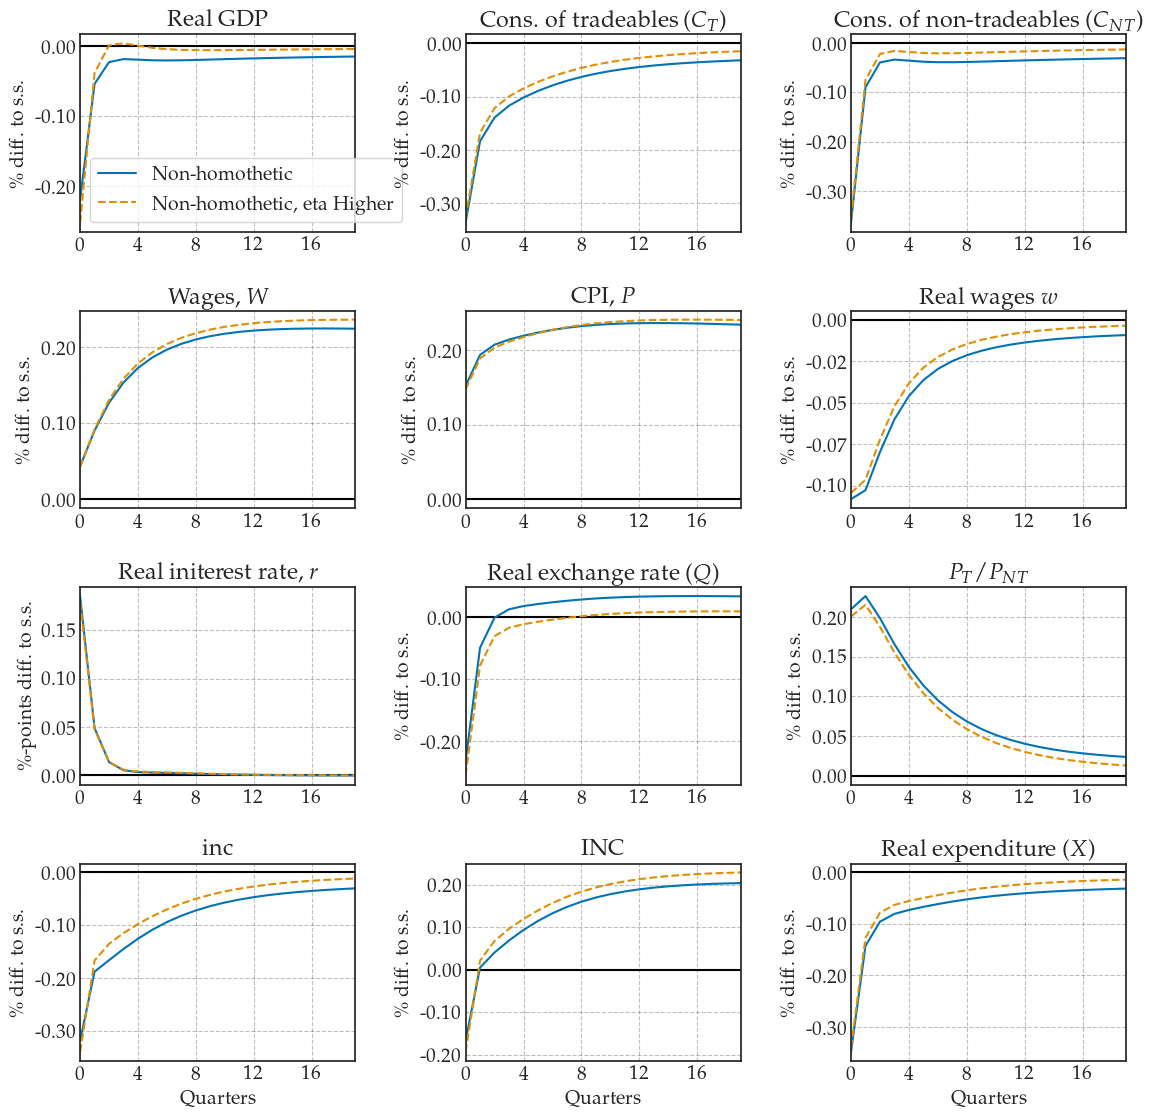

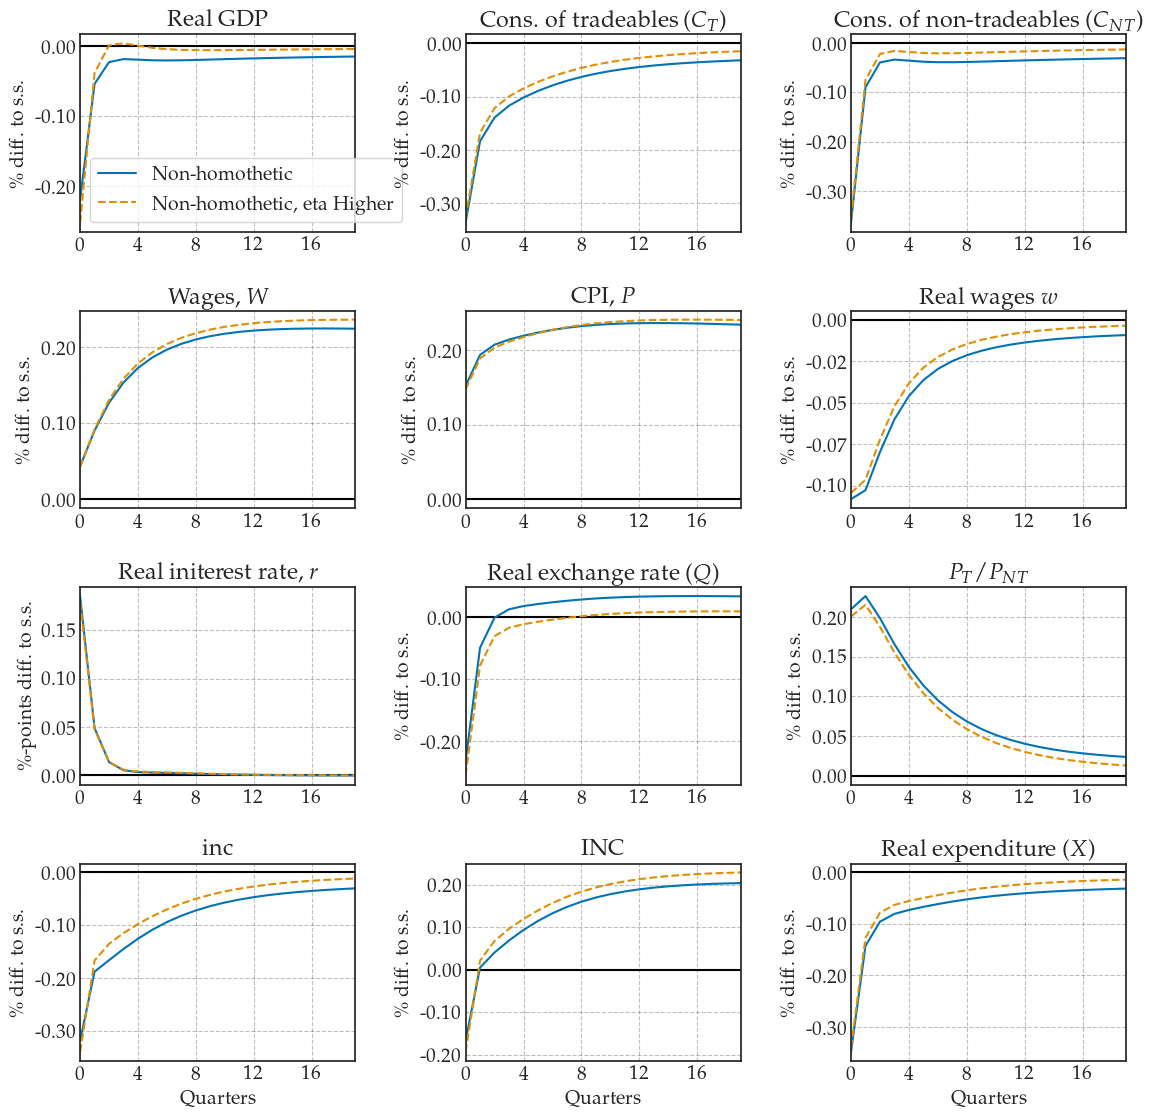

In [22]:
figs.show_IRFs([model_NH,model_alt])

In [23]:
model_alt_H = IHANKModelClass(name='Non-homothetic, eta Higher')
model_alt_H.par.epsilon = 0.0
model_alt_H.par.gamma = 0.12

model_alt_H.find_ss()
model_alt_H.compute_jacs()
model_alt_H.find_transition_path(shock, do_end_check=False)


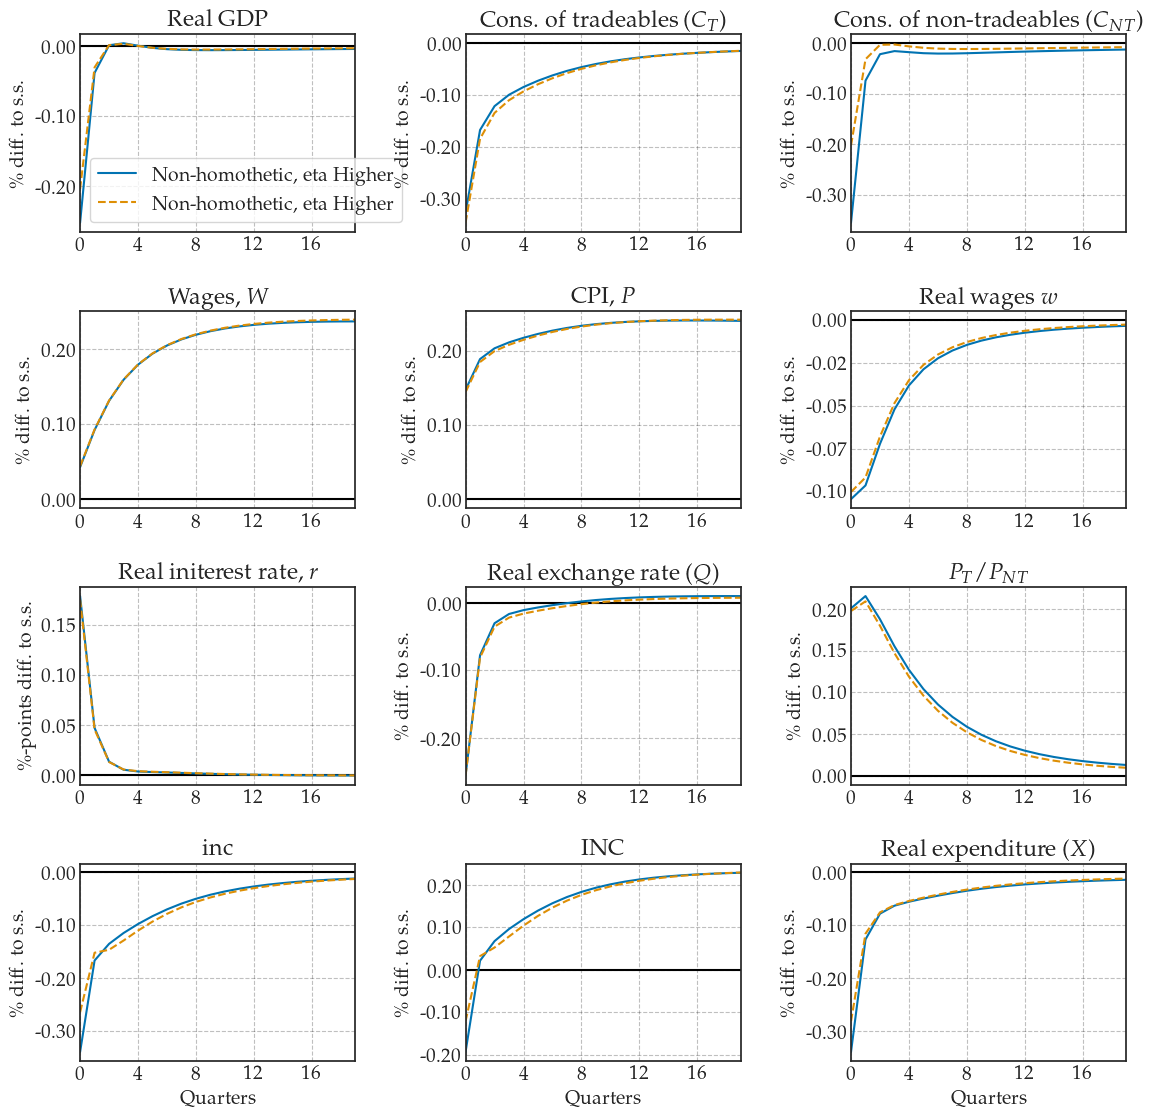

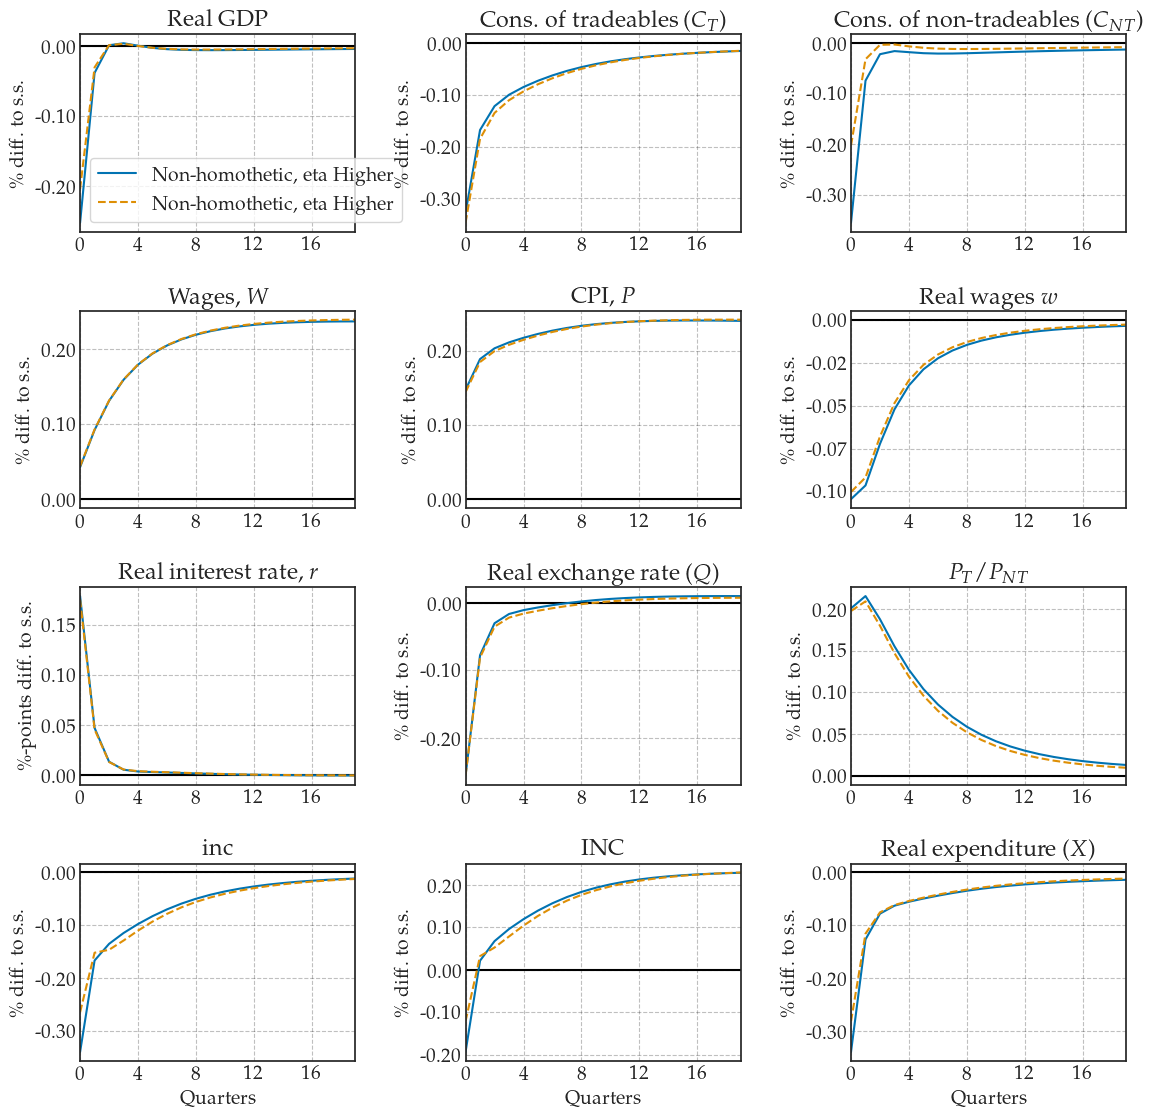

: 

In [24]:
figs.show_IRFs([model_alt,model_alt_H])

In [7]:
model_H = IHANKModelClass(name='Homothetic')
model_H.par.epsilon = 0.0
model_H.par.gamma =  model_H.par.gamma_homo
model_H.find_ss()
model_H.compute_jacs()
model_H.find_transition_path(shock, do_end_check=False)

In [9]:
models = [model_NH, model_H]

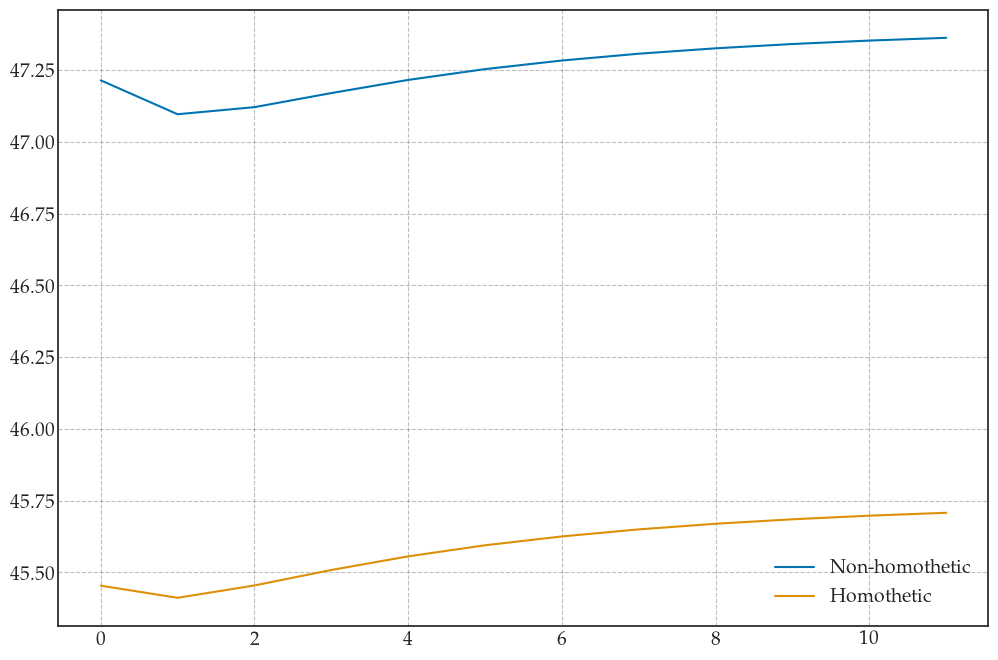

In [17]:
fig = plt.figure(figsize=(12, 8))

ax = fig.add_subplot(1, 1, 1)

for model in models:
    imports_ = ((model.path.CE + model.path.CTF)/(model.path.CTF+ model.path.CE+ model.path.CTH+model.path.CNT) / (model.ss.CE + model.ss.CTF)/(model.ss.CTF+ model.ss.CE+ model.ss.CTH+model.ss.CNT)-1)*100
    ax.plot( imports_[:12], label=model.name)

ax.legend()

In [3]:
model_NH = model.copy(name='Non-Homothetic Preferences')
# model_NH.par.gamma = model_NH.par.epsilon
# model_NH.par.epsilon = 0.22
# model_NH.par.gamma = 0.45
# model_NH.par.nu  = 0.55
# model_NH.par.alphaE  = 0.18
# model_NH.par.tau_ss  = 0.20
# model_NH.par.alphaF  = 0.3

# model_NH.par.eta_s = 0.5
# model_NH.par.etaF = 0.5
# model_NH.par.etaE = 0.1


# model_NH.par.eta_s = 2.0
# model_NH.par.etaF = 2.0
# model_NH.par.etaE = 0.4

# model_NH.par.mu_p = 1.1
# model_NH.par.mu_w = 1.1
# model_NH.par.sigma_psi = 0.13
model_NH.find_ss()
model_NH.compute_jacs(do_print=False)
model_NH.find_transition_path(shocks=shock, do_end_check=False)



KeyboardInterrupt: 

In [4]:
model_NH.par.eta_T_RA

0.240106633213372

In [8]:
# gamma_ = 0.4

# model_.par.gamma = gamma_

gamma_list = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
eta_list = []

for gamma_ in gamma_list:
    try: 
        model_ = model.copy(name='Test')
        model_.par.epsilon = 0.0
        model_.find_ss()

        
        print(f" gamma={gamma_}, eta =  {model_.par.eta_T_RA}")

        eta_list.append(model_.par.eta_T_RA)

    except Exception as e:
        print(f" gamma={gamma_}, eta X  {e}")
        eta_list.append(np.nan)


 gamma=0.0, eta =  -1.1102230246251565e-16
 gamma=0.1, eta =  -1.1102230246251565e-16
 gamma=0.2, eta =  -1.1102230246251565e-16
 gamma=0.3, eta =  -1.1102230246251565e-16


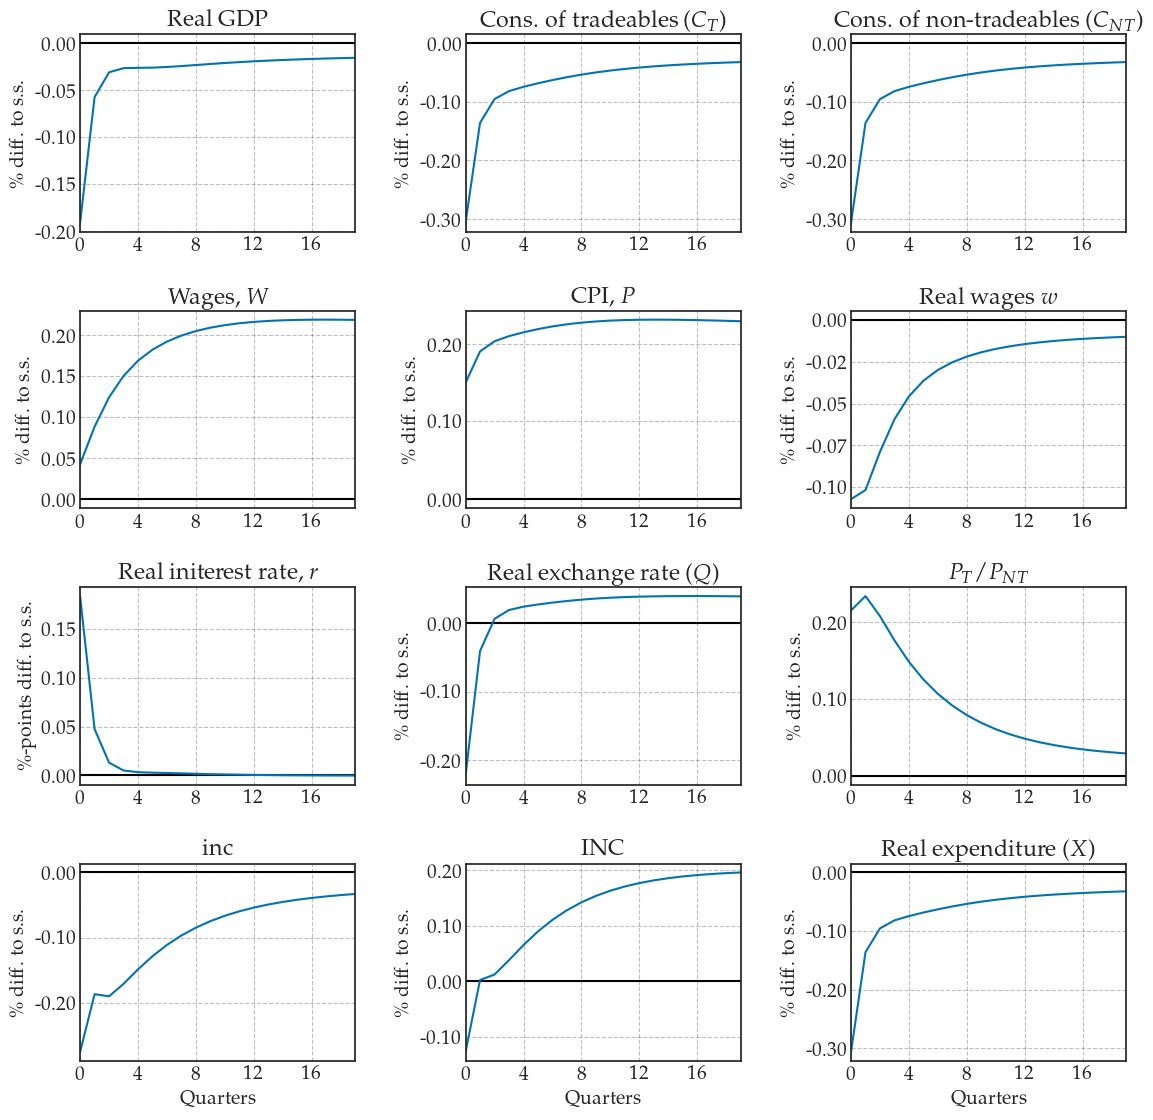

In [3]:
try: 
    model_ = model.copy(name='Test')
    model_.par.epsilon = 0.0
    model_.find_ss()
    model_.compute_jacs(do_print=False)
    model_.find_transition_path(shocks=shock, do_end_check=False)
    figs.show_IRFs([model_])
except Exception as e:
    print(f"Error in model computation: {e}")
    model_ = None

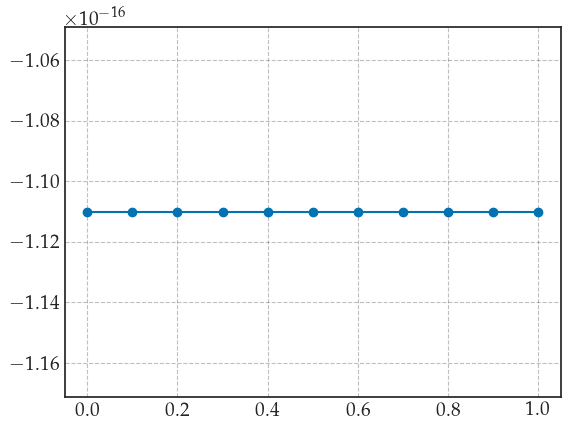

In [7]:
plt.plot(gamma_list, eta_list, marker='o', linestyle='-')

In [12]:
def shares(model):
    print(f'Non-tradable share: {model.ss.CNT/(model.ss.CNT+ model.ss.CT)*100:.1f}')
    print(f'Energy share: {model.ss.CE/(model.ss.CNT+ model.ss.CT)*100:.1f}')
    print(f'Consumption home tradable share: {model.ss.CTH/(model.ss.CNT+ model.ss.CT)*100:.1f}')
    print(f'Consumption forigne tradable share: {model.ss.CTF/(model.ss.CNT+ model.ss.CT)*100:.1f}')
    print(f'Import share of tradables: {(model.ss.CE+ model.ss.CTF)/(model.ss.CT)*100:.1f}')
    print(f'Government share: {model.ss.G/(model.ss.GDP)*100:.1f}')



shares(model_NH)

Non-tradable share: 43.6
Energy share: 10.1
Consumption home tradable share: 32.3
Consumption forigne tradable share: 13.9
Import share of tradables: 42.6
Government share: 17.6


In [4]:
model_NHCES = model_NH.copy(name = 'Non-homothetic CES')

model_NHCES.par.gamma = model_NHCES.par.epsilon 

model_NHCES.find_ss()
model_NHCES.compute_jacs(do_print=False)
model_NHCES.find_transition_path(shocks=shock, do_end_check=False)

In [5]:
model_CD = model_NH.copy(name = 'Cubb-douglas')

model_CD.par.epsilon = 0.0
model_CD.par.gamma = 0.0

model_CD.find_ss()
model_CD.compute_jacs(do_print=False)
model_CD.find_transition_path(shocks=shock, do_end_check=False)

In [102]:
model_H_etaNH = model_NH.copy(name = 'Cubb-douglas')

model_H_etaNH.par.epsilon = 0.0
print(r'$\gamma$ TBD')
# model_H_etaNH.par.gamma = 
pass 
model_H_etaNH.find_ss()
model_H_etaNH.compute_jacs(do_print=False)
model_H_etaNH.find_transition_path(shocks=shock, do_end_check=False)

NameError: name 'model_NH' is not defined

In [6]:
models = [model_NH, model_NHCES, model_CD]

for model in models: 
    print(model.name)
    print(f'eta T = {model.par.eta_T_RA}')
    print(f'omega T = {model.par.omega_T}')
    print('\n')

Non-Homothetic Preferences
eta T = 0.37761677440668584
omega T = 0.42059772817869495


Non-homothetic CES
eta T = 0.78
omega T = 0.42059772817869495


Cubb-douglas
eta T = 1.0
omega T = 0.4000000000000001




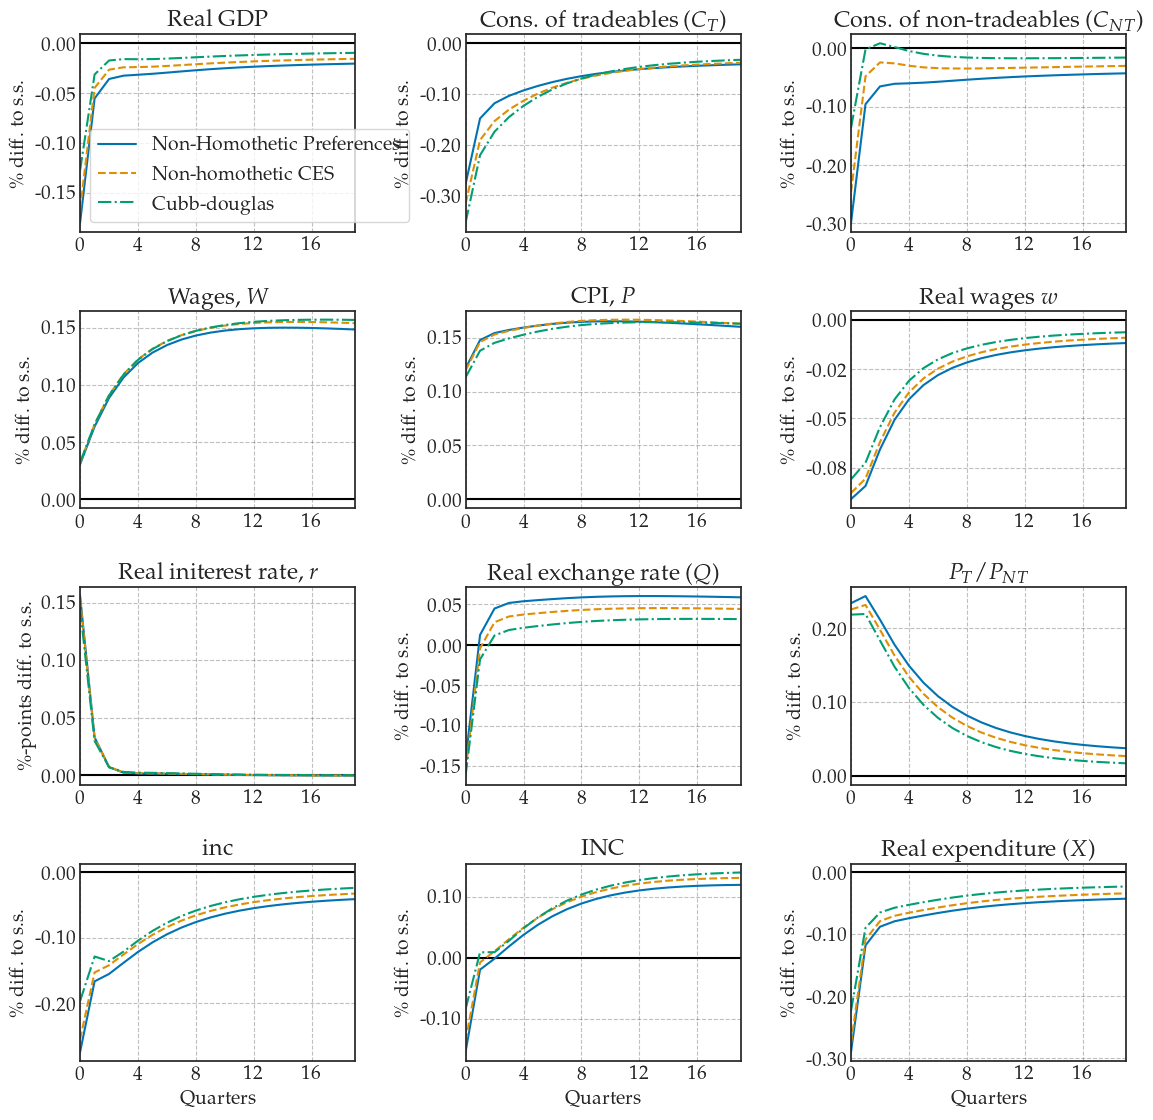

In [7]:
fig = figs.show_IRFs(models)

In [100]:
for model in models: 
    print(model.name)
    print(f'eta T = {model.par.eta_T_RA}')
    print(f'omega T = {model.par.omega_T}')
    print('\n')

Test Non-Homothetic Preferences
eta T = 0.37964128488050053
omega T = 0.41775999498001115


Non-homothetic CES
eta T = 0.78
omega T = 0.41775999498001115


test Homothetic
eta T = 1.0
omega T = 0.39999999999999997




In [3]:
model_baseline = model.copy(name='Non-Homothetic Preferences')
# model_baseline.par.gamma = model_baseline.par.epsilon
model_baseline.find_ss()
model_baseline.compute_jacs(do_print=False)
model_baseline.find_transition_path(shocks=shock, do_end_check=False)

In [4]:
model_baseline_h = model.copy(name='Basline Homothetic Preferences')
model_baseline_h.par.epsilon = 0.0
model_baseline_h.par.gamma = 0.18
model_baseline_h.find_ss()
model_baseline_h.compute_jacs(do_print=False)
model_baseline_h.find_transition_path(shocks=shock, do_end_check=False)

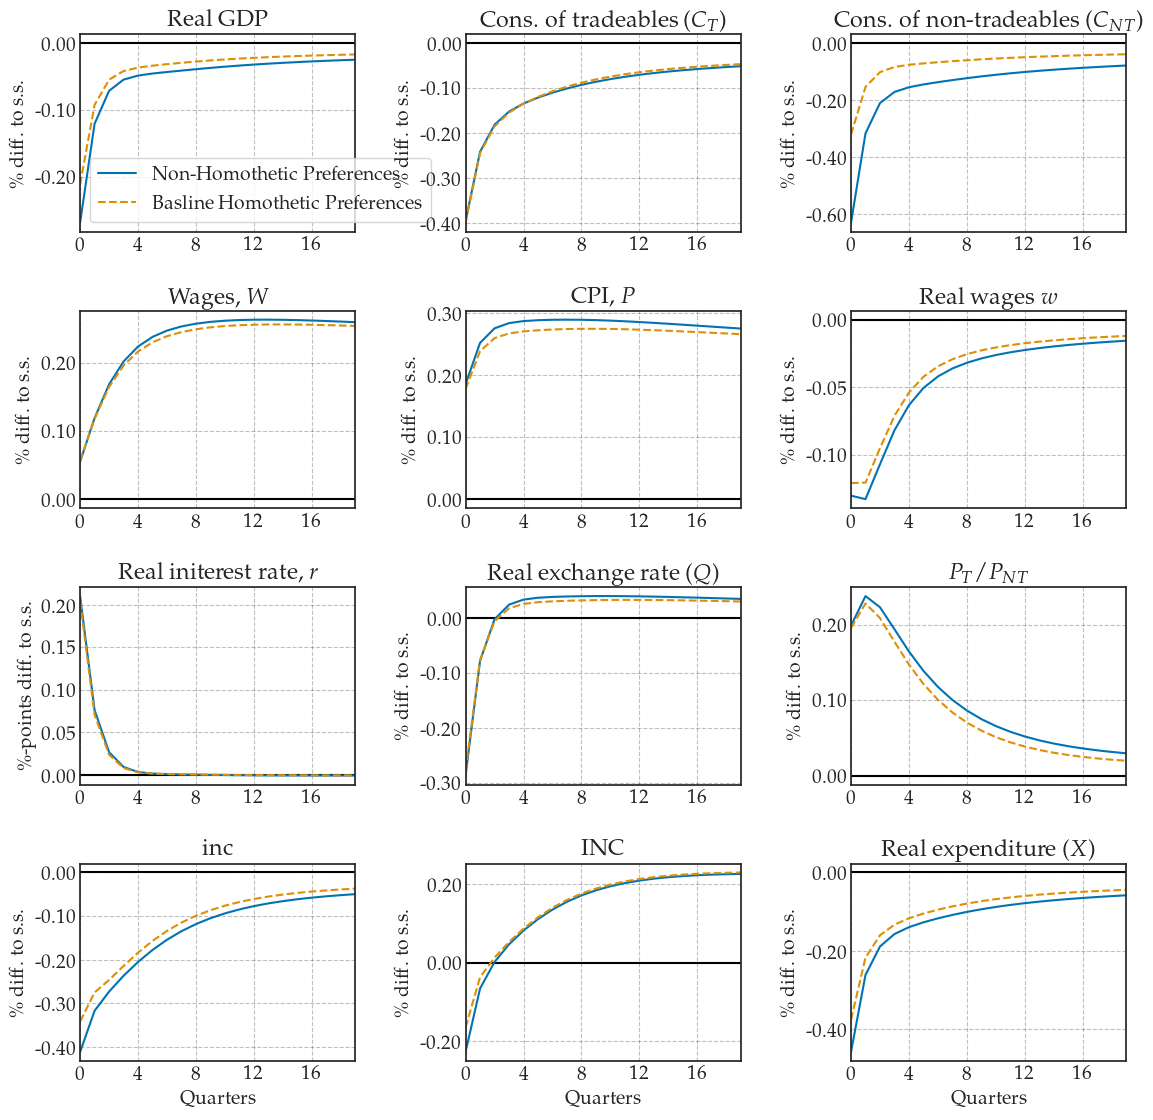

In [5]:
fig = figs.show_IRFs([model_baseline, model_baseline_h])

In [5]:
model_baseline.ss.CNT/(model_baseline.ss.CNT + model_baseline.ss.CT)

0.2679537473833023

In [6]:
model_baseline.par.nu

0.7

In [11]:
model_low_nu = IHANKModelClass()
model_low_nu.par.nu = 0.475
model_low_nu.find_ss()



In [12]:
model_low_nu.ss.CNT/(model_low_nu.ss.CNT + model_low_nu.ss.CT)

0.503254328581693

In [ ]:

def ann_MPCs(self, shock_type='income', return_shock=False):
    """ calculate MPCs """

    # a. shock
    self._set_inputs_hh_all_ss()
    
    if shock_type == 'income':
        # 5 percent of labor income
        self.path.UniformT[:,:] = 0.0 
        self.path.UniformT[0,0] = 0.05 * (self.ss.WT * self.ss.NT + self.ss.WNT * self.ss.NNT)
        dI = self.path.UniformT[0,0]    



    # b. solve and simulate    
    self.solve_hh_path()
    self.simulate_hh_path()
    
    # c. calculate MPCs
    MPC = np.zeros(self.par.T)*np.nan

    C_ss = np.sum(self.ss.c*self.ss.D)    
    for t in range(self.par.T):
        MPC[t] = (np.sum(self.path.c[t]*self.path.D[t])-C_ss)/dI
        
    ann_MPC = np.zeros(round(self.par.T/4))

    for j in range(round(self.par.T/4)):
        ann_MPC[j] = np.sum(MPC[j*4:(1+j)*4])  
    
    # d. reset
    self._set_inputs_hh_all_ss()
    
    if return_shock:
        return ann_MPC, MPC, dI 
    else:
        return ann_MPC, MPC



In [3]:
# Flexible prices
model_flex = model.copy(name='Flexible Prices')
model_flex.par.kappa_w = 1000.0
model_flex.par.real_wage_motive = 0.0
model_flex.find_ss()
model_flex.compute_jacs(do_print=False)
model_flex.find_transition_path(shocks=shock, do_end_check=False)


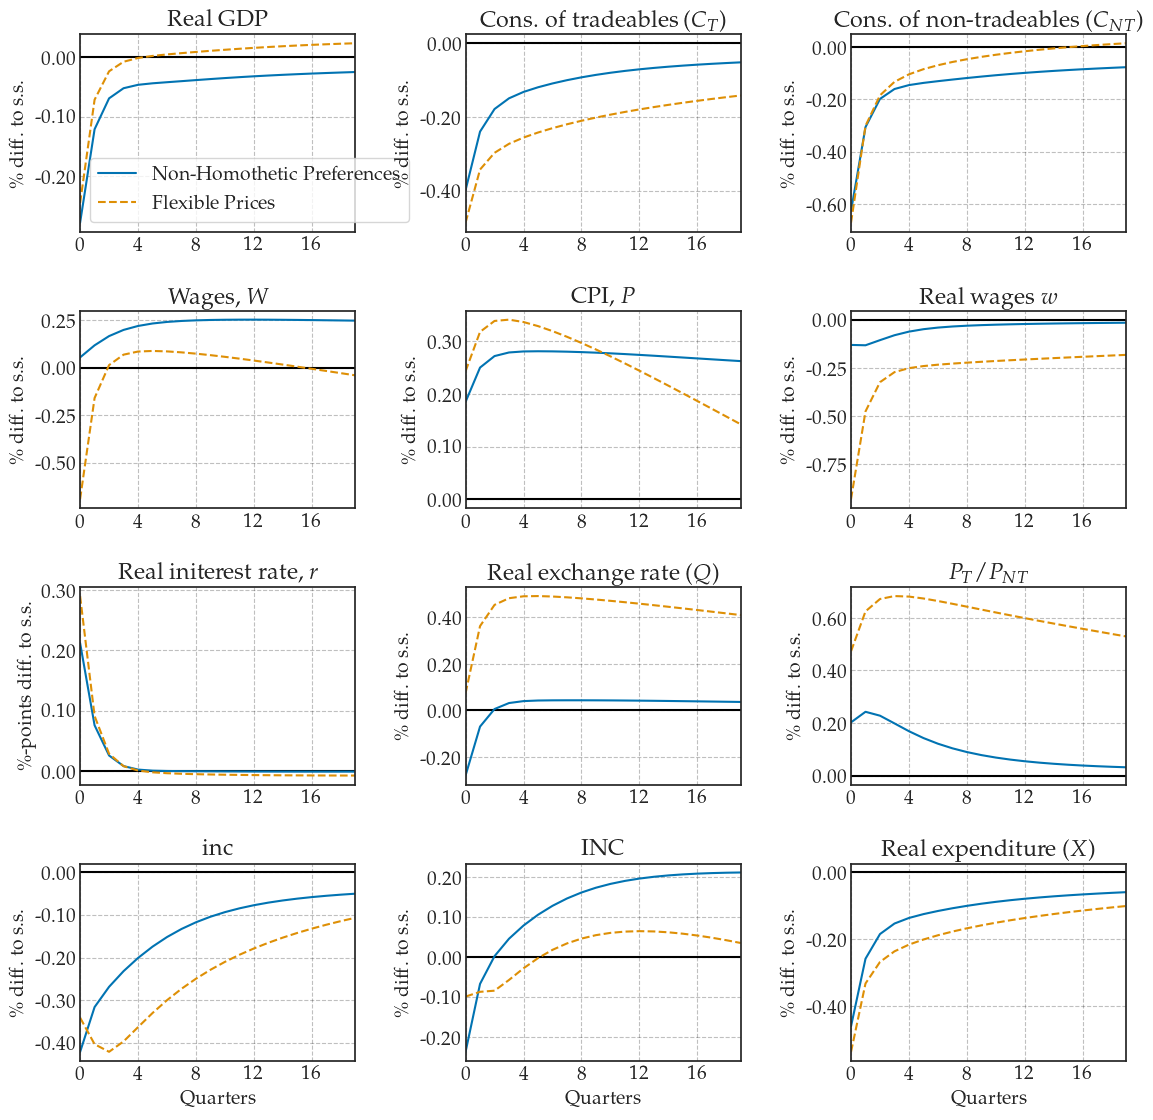

In [5]:
fig = figs.show_IRFs([model_baseline, model_flex])

In [ ]:
model_homothetic = model.copy(name='Homothetic Preferences')
model_homothetic.par.epsilon = 0.0
model_homothetic.par.gamma = 0.18
# model_homothetic.par.gamma = 0.055
model_homothetic.find_ss()
model_homothetic.compute_jacs()
model_homothetic.find_transition_path(shocks=shock, do_end_check=False)

In [ ]:
models = [model_baseline, model_homothetic]

# Basics

In [ ]:
fig = figs.plot_policy(model_baseline, ['e', 'cnt', 'ct'])
if save_figs: fig.savefig('plots/policy.png', dpi=300, bbox_inches='tight')


In [ ]:
fig = figs.cum_z_a(model_baseline)
if save_figs: fig.savefig('plots/cum_z_a.png', dpi=300, bbox_inches='tight')


In [ ]:
fig = figs.plot_trans_matrix(model_baseline)
if save_figs: fig.savefig('plots/z_trans.png', dpi=300, bbox_inches='tight')

# Shock 


In [ ]:
fig = figs.plot_PE_s(model_baseline)
if save_figs: fig.savefig('plots/PE_shock.png', dpi=300, bbox_inches='tight')

# Jacobians 

In [ ]:
fig = figs.plot_jac_p(models)
if save_figs: fig.savefig('plots/jac_p.png', dpi=300, bbox_inches='tight')

# IRF's

### All

In [ ]:
paths_ = ['PE', 'P', 'w', 'CE', 'C_hh', 'C_hh','YH', 'X' , 'C_hh']
fig = figs.show_IRFs(models, paths_, T_max=100)
if save_figs: fig.savefig('plots/IRFs_intro.png', dpi=300, bbox_inches='tight')

In [ ]:
paths_ = ['YH', 'P', 'w','X','r_real', 'p' ]
fig = figs.show_IRFs(models, paths_, T_max=100)
if save_figs: fig.savefig('plots/IRFs_main.png', dpi=300, bbox_inches='tight')

In [ ]:
paths_ = ['CT_hh', 'CNT_hh', 'PNT', 'PT']
fig =  figs.show_IRFs([model_baseline, model_homothetic], paths_, maxcol=2, T_max=100)
if save_figs: fig.savefig(f'plots/IRFs_c.png', dpi=300, bbox_inches='tight')

### IRF's prices

In [ ]:
fig =  figs.show_pc_IRFs(model_baseline)
if save_figs: fig.savefig(f'plots/IRFs_pc_all.png', dpi=300, bbox_inches='tight')

In [ ]:
fig =  figs.show_pc_IRFs(model_homothetic)
if save_figs: fig.savefig(f'plots/IRFs_pc_all_homo.png', dpi=300, bbox_inches='tight')

In [ ]:

# fig =  figs.show_pc_IRFs(model_baseline)
# if save_figs: fig.savefig(f'plots/IRFs_pc_all.png', dpi=300, bbox_inches='tight')



# fig =  figs.show_price_IRFs(model_baseline)
# if save_figs: fig.savefig(f'plots/IRFs_p_all.png', dpi=300, bbox_inches='tight')



# fig =  figs.show_c_IRFs(model_baseline)
# if save_figs: fig.savefig(f'plots/IRFs_c_all.png', dpi=300, bbox_inches='tight')

# Importance of epsilon 

In [ ]:
model_e1 = IHANKModelClass(name='epsion = 0.10')
model_e1.par.epsilon = 0.10
# model_e1.par.gamma = 0.24
model_e1.find_ss()
model_e1.compute_jacs()
model_e1.find_transition_path(shocks=shock, do_end_check=False)

model_e05 = IHANKModelClass(name='epsion = 0.05')
model_e05.par.epsilon = 0.05
# model_e05.par.gamma = 0.21
model_e05.find_ss()
model_e05.compute_jacs()
model_e05.find_transition_path(shocks=shock, do_end_check=False)


In [ ]:
model_e00 = IHANKModelClass(name='epsion = 0.00')
model_e00.par.epsilon = 0.00
# model_e00.par.gamma = 0.21
model_e00.find_ss()
model_e00.compute_jacs()
model_e00.find_transition_path(shocks=shock, do_end_check=False)

In [ ]:
models = [model_baseline,  model_e1, model_e05 , model_e00]#, model_homothetic]
for model_i in models:
    model_i.calc_additional_new()
    model_i.name = f'cov = {model_i.cov_e_omegaT:.3f}'
    
colors_reds = sns.color_palette("Reds", n_colors=5)
fig = figs.show_IRFs(models, paths=['P', 'X', 'CT', 'CNT' ], colors = colors_reds, maxcol=2)
# if save_figs: fig.savefig('plots/IRFs_epsion.png', dpi=300, bbox_inches='tight')

In [ ]:


def show_IRFs(models, colors):

    ncols = 2
    nrows = 2
    T_max = 17
    linewidth= 1.0

    fig = plt.figure(figsize=(4.3*ncols/1.1,3.6*nrows/1.2),dpi=100)
    # Tradable and  non-tradable
    # fig.suptitle(f'{model[0].name}, Consumption Response', fontsize=20)
    
    ax = fig.add_subplot(nrows,ncols,1)   
    for i, model in enumerate(models): 
    # ax.plot((model.path.p-model.ss.p),label='$p$', linewidth=linewidth)
        ax.plot(((model.path.P-model.ss.P)/model.ss.P-1)*100,label='$C_T$', linewidth=linewidth, color= colors[i])
        # ax.plot(((model.path.CNT-model.ss.CNT)/model.ss.CNT),ls='--',label='$C_{NT}$', linewidth=linewidth)
    # ax.plot((model.path.PNT-model.ss.PNT),ls=':',label='$P_{NT}$', linewidth=linewidth)
    ax.set_xlim([0,T_max])
    ax.set_ylabel('\% diff. to s.s.')
    # ax.legend()
    ax.set_title('CPI (P)')
    ax.set_xlabel('Quarters')
    ax.set_xticks(np.arange(0,T_max,4))

    # Energy and non energy tradable 
    ax = fig.add_subplot(nrows,ncols,2)    
    for model in models: 
        ax.plot(((model.path.X-model.ss.X)/model.ss.X-1),label='$C_E$', linewidth=linewidth, color= colors[i])
        # ax.plot(((model.path.CTHF-model.ss.CTHF)/model.ss.CTHF),ls='--',label='$C_{goods}$', linewidth=linewidth)
    # ax.plot((model.path.PE-model.ss.PE),ls=':',label='$P_{Energy}$', linewidth=linewidth)
    ax.set_ylabel('\% diff. to s.s.')
    ax.set_xlim([0,T_max])
    # ax.legend()
    ax.set_title('Real Expenditure')
    ax.set_xlabel('Quarters')
    ax.set_xticks(np.arange(0,T_max,4))
    
    ax = fig.add_subplot(nrows,ncols,3)   
    for i, model in enumerate(models): 
    # ax.plot((model.path.p-model.ss.p),label='$p$', linewidth=linewidth)
        ax.plot(((model.path.CT-model.ss.CT)/model.ss.CT-1),label='$C_T$', linewidth=linewidth, color= colors[i])
        # ax.plot(((model.path.CNT-model.ss.CNT)/model.ss.CNT),ls='--',label='$C_{NT}$', linewidth=linewidth)
    # ax.plot((model.path.PNT-model.ss.PNT),ls=':',label='$P_{NT}$', linewidth=linewidth)
    ax.set_xlim([0,T_max])
    ax.set_ylabel('\% diff. to s.s.')
    # ax.legend()
    ax.set_title('Cons. Tradable goods')
    ax.set_xlabel('Quarters')
    ax.set_xticks(np.arange(0,T_max,4))

    # Energy and non energy tradable 
    ax = fig.add_subplot(nrows,ncols,4)    
    for model in models: 
        ax.plot(((model.path.CNT-model.ss.CNT)/model.ss.CNT-1)*100,label='$C_E$', linewidth=linewidth, color= colors[i])
        # ax.plot(((model.path.CTHF-model.ss.CTHF)/model.ss.CTHF),ls='--',label='$C_{goods}$', linewidth=linewidth)
    # ax.plot((model.path.PE-model.ss.PE),ls=':',label='$P_{Energy}$', linewidth=linewidth)
    ax.set_ylabel('\% diff. to s.s.')
    ax.set_xlim([0,T_max])
    # ax.legend()
    ax.set_title('Cons. Non-tradable services')
    ax.set_xlabel('Quarters')
    ax.set_xticks(np.arange(0,T_max,4))


    fig.tight_layout()

    return fig

colors_reds = sns.color_palette("Reds", n_colors=4)
models = [model_baseline, model_homothetic]
fig = show_IRFs(models, colors_reds)


# Importance of gamma

In [ ]:
model_g29 = model_baseline.copy()


In [ ]:
model_g40 = IHANKModelClass(name='gamma = 0.40')
model_g40.par.gamma = 0.40
model_g40.find_ss()
model_g40.compute_jacs()
model_g40.find_transition_path(shocks=shock, do_end_check=False)


In [ ]:
model_g20 = IHANKModelClass(name='gamma = 0.20')
model_g20.par.gamma = 0.20
model_g20.find_ss()
model_g20.compute_jacs()
model_g20.find_transition_path(shocks=shock, do_end_check=False)

In [ ]:
models = [model_g20, model_baseline,  model_g40]
for model_i in models:
    model_i.calc_additional_new()
    model_i.name = f'eta = {model_i.par.eta_T_RA:.3f}'
    
colors_reds = sns.color_palette("Reds", n_colors=3)
path_eta = ['CT', 'CNT', 'YH', 'X'] 
fig = figs.show_IRFs(models, path_eta, colors = colors_reds, maxcol=2)
if save_figs: fig.savefig('plots/IRFs_gamma.png', dpi=300, bbox_inches='tight')

# Effect of real wage stabilisation motive 

### Results 

In [ ]:
model_no_ws = IHANKModelClass(name='$\zeta = 0$')
model_no_ws.par.real_wage_motive = 0.0
model_no_ws.find_ss()
model_no_ws.compute_jacs()
model_no_ws.find_transition_path(shocks=shock, do_end_check=False)


In [ ]:
paths_wage_stabilisation = ['W', 'P', 'w']
model_baseline.name = '$\zeta = 5.0$'
fig = figs.show_IRFs([model_baseline, model_no_ws], paths_wage_stabilisation, maxcol=3)
if save_figs: fig.savefig('plots/IRFs_wp_spiral.png', dpi=300, bbox_inches='tight')

### IRFs robustness

In [ ]:
model_no_ws_homo = IHANKModelClass(name='$\zeta = 0 Homo$')
model_no_ws_homo.par.real_wage_motive = 0.0
model_no_ws_homo.par.epsilon = 0.0
model_no_ws_homo.par.gamma = 0.18
model_no_ws_homo.find_ss()
model_no_ws_homo.compute_jacs()
model_no_ws_homo.find_transition_path(shocks=shock, do_end_check=False)

In [ ]:
model_no_ws.name = '$\zeta = 0$ Non-homothetic'
model_no_ws_homo.name = '$\zeta = 0$ Homothetic'
fig = figs.show_IRFs([ model_no_ws, model_no_ws_homo], maxcol=3)
if save_figs: fig.savefig('plots/IRFs_real_wage_motive.png', dpi=300, bbox_inches='tight')

# Consumption

### Goods and services

# Correlations

In [ ]:
# model_baseline.calc_additional_new()
fig = figs.plot_cor_e(model_baseline)
if save_figs: fig.savefig('plots/cor_e.png', dpi=300, bbox_inches='tight')

# Forigne economy 

In [ ]:

paths_forigne = ['i', 'r_real', 'E', 'Q', 'PTH', 'CTH_s' ]
fig = figs.show_IRFs(models, paths_forigne)
if save_figs: fig.savefig('plots/IRFs_forigne.png', dpi=300, bbox_inches='tight')

# No wage stabilisation motive

# Other elasticities of substitution

### Eta E

In [ ]:
model_etaE05 = IHANKModelClass(name= '$\eta_E = 0.5$')
model_etaE05.par.etaE = 0.5
model_etaE05.find_ss()
model_etaE05.compute_jacs()
model_etaE05.find_transition_path(shock, do_end_check=False)

In [ ]:
model_etaE2 = IHANKModelClass(name= '$\eta_E = 2$')
model_etaE2.par.etaE = 2.0
model_etaE2.find_ss()
model_etaE2.compute_jacs()
model_etaE2.find_transition_path(shock, do_end_check=False)


In [ ]:
model_etaE5 = IHANKModelClass(name= '$\eta_E = 5$')
model_etaE5.par.etaE = 5.0
model_etaE5.find_ss()
model_etaE5.compute_jacs()
model_etaE5.find_transition_path(shock, do_end_check=False)


In [ ]:
model_baseline.name = '$\eta_E =0.0$'
models = [model_baseline, model_etaE05 , model_etaE2, model_etaE5]
paths_ = ['CE','YH', 'X']
fig = figs.show_IRFs(models, paths_)
if save_figs: fig.savefig('plots/eta_E.png', dpi=300, bbox_inches='tight')

### Eta F and eta S 

In [ ]:
model_etaF1 = IHANKModelClass(name= 'Eta = 1.0')
model_etaF1.par.etaF = 1.0
model_etaF1.par.eta_s = 1.0
model_etaF1.find_ss()
model_etaF1.compute_jacs()
model_etaF1.find_transition_path(shock, do_end_check=False)

In [ ]:
model_etaF2 = IHANKModelClass(name= 'Eta = 2.0')
model_etaF2.par.etaF = 2.0
model_etaF2.par.eta_s = 2.0
model_etaF2.find_ss()
model_etaF2.compute_jacs()
model_etaF2.find_transition_path(shock, do_end_check=False)

In [ ]:
model_etaF5 = IHANKModelClass(name= 'Eta = 3.0')
model_etaF5.par.etaF = 3.0
model_etaF5.par.eta_s = 3.0
model_etaF5.find_ss()
model_etaF5.compute_jacs()
model_etaF5.find_transition_path(shock, do_end_check=False)

In [ ]:
model_baseline.name = 'Eta = 0.5'
models = [model_baseline, model_etaF1 , model_etaF2, model_etaF5]

paths_ = ['PTH', 'E', 'PTH_s', 'CTH', 'CTF', 'CTH_s' , 'X', 'PF']
# paths_ = [ 'CTH', 'CTF', 'CTH_s' , 'X']
fig = figs.show_IRFs(models, paths_)
# if save_figs: fig.savefig('plots/eta_F.png', dpi=300, bbox_inches='tight')

# Energy share

In [ ]:
# High energy 
model_EHigh = IHANKModelClass(name = 'High Energy')
model_EHigh.par.alphaE = model_baseline.par.alphaE *2
model_EHigh.find_ss()
model_EHigh.compute_jacs()
model_EHigh.find_transition_path(shock, do_end_check=False)


# High energy 
model_ELow = IHANKModelClass(name = 'Low Energy')
model_ELow.par.alphaE = model_baseline.par.alphaE /2
model_ELow.find_ss()
model_ELow.compute_jacs()
model_ELow.find_transition_path(shock, do_end_check=False)

In [ ]:
paths = []
fig = figs.show_IRFs([model_ELow,model_baseline, model_EHigh])
if save_figs: fig.savefig('plots/eta_F.png', dpi=300, bbox_inches='tight')

# Monetary Policy

In [ ]:
model_tight = IHANKModelClass(name='Tight mon policy')
model_tight.par.phi = 2.0
model_tight.find_ss()
model_tight.compute_jacs()
model_tight.find_transition_path(shocks=shock, do_end_check=False)

In [ ]:
# In notbook_complete2 copy
# hh_state_basline 
fig = figs.show_IRFs([model_baseline, model_tight])